In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# importing the data
cls_df = pd.read_csv('course_lead_scoring.csv')
cls_df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
# check if missing values are present
cls_df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
cls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [5]:
# separating categorical and numerical columns
cat_cols  = list(cls_df.select_dtypes(include=['object', 'category']).columns)

# all num cols except the target col (since target col did not have any null and will be easier for future operations)
num_cols = list(cls_df.select_dtypes(include=np.number).columns)
num_cols.remove('converted')

print(cat_cols, num_cols, sep='\n\n')

['lead_source', 'industry', 'employment_status', 'location']

['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [6]:
cls_df.isnull().any()

lead_source                  True
industry                     True
number_of_courses_viewed    False
annual_income                True
employment_status            True
location                     True
interaction_count           False
lead_score                  False
converted                   False
dtype: bool

In [7]:
# filling nulls of cat and num features

for col in cls_df.columns[cls_df.isna().any()]:
    
    # for cat cols
    if col in cat_cols:
        print('cat', col)
        cls_df[col].fillna('NA', inplace=True)
        
    # filling num cols
    elif col in num_cols:
        print('num', col)
        cls_df[col].fillna(0.0,inplace=True)
        
print(cls_df.info())
print()
print(cls_df.isna().sum())

cat lead_source
cat industry
num annual_income
cat employment_status
cat location
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1462 non-null   object 
 1   industry                  1462 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1462 non-null   float64
 4   employment_status         1462 non-null   object 
 5   location                  1462 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB
None

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status

In [8]:
# splitting data into train 60%, validation 20%, test 20%
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(cls_df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# checking the split count and proportion
print(len(df_train), len(df_val), len(df_test))
print(round(len(df_train)/len(cls_df), 2), round(len(df_val)/len(cls_df), 2), round(len(df_test)/len(cls_df), 2))

876 293 293
0.6 0.2 0.2


In [9]:
# reset indices of the train val test split dataframes
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
# extract target variables from the splits
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [11]:
# drop the target vars from the features
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [12]:
# importing roc auc evaluation metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [13]:
# QUESTION 1

auc_num_cols_dict = {}

# looping through num features
for num_col in num_cols:
    auc_num_cols_dict[num_col] = roc_auc_score(y_train, df_train[num_col])

print(auc_num_cols_dict)

{'number_of_courses_viewed': 0.7635680590007088, 'annual_income': 0.5519578313253012, 'interaction_count': 0.738270176293409, 'lead_score': 0.6144993577250176}


In [14]:
# check if any feature's auc is below 0.5
print({feature: auc_score for feature, auc_score in auc_num_cols_dict.items() if auc_score < 0.5})

{}


In [15]:
# since none of the values are below 0.5 auc score,  sorting the features with highest correlation at the top
dict(sorted(auc_num_cols_dict.items(), key=lambda item: item[1], reverse=True))

{'number_of_courses_viewed': 0.7635680590007088,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176,
 'annual_income': 0.5519578313253012}

The numerical variable with highest AUC: number_of_courses_viewed with a score of 0.7635 (approx)

In [16]:
zxcvb = cat_cols + num_cols
cls_df[zxcvb].head()

,lead_source,industry,employment_status,location,number_of_courses_viewed,annual_income,interaction_count,lead_score
0,paid_ads,NA,unemployed,south_america,1,79450.0,4,0.94
1,social_media,retail,employed,south_america,1,46992.0,1,0.80
2,events,healthcare,unemployed,australia,5,78796.0,3,0.69
3,paid_ads,retail,NA,australia,2,83843.0,1,0.87
4,referral,education,self_employed,europe,3,85012.0,3,0.62


In [17]:
cls_df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [18]:
df_train

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
0,events,manufacturing,2,95543.0,unemployed,europe,3,0.78
1,referral,NA,1,54924.0,student,south_america,6,0.39
2,organic_search,healthcare,2,77352.0,unemployed,europe,2,0.22
3,paid_ads,other,2,34600.0,employed,south_america,2,0.31
4,paid_ads,education,0,43615.0,unemployed,south_america,2,0.01
...,...,...,...,...,...,...,...,...
871,NA,other,5,67314.0,NA,europe,2,0.87
872,events,education,6,63996.0,NA,australia,4,0.92
873,organic_search,finance,1,73702.0,unemployed,north_america,2,0.55
874,events,technology,1,93341.0,student,middle_east,4,0.99


In [19]:
df_val

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
0,organic_search,manufacturing,1,0.0,NA,asia,0,0.73
1,referral,education,2,58777.0,NA,north_america,0,0.94
2,paid_ads,technology,3,78148.0,employed,middle_east,2,0.80
3,social_media,technology,3,63854.0,employed,africa,1,0.10
4,referral,education,1,69099.0,unemployed,africa,4,0.98
...,...,...,...,...,...,...,...,...
288,paid_ads,finance,2,41947.0,self_employed,europe,4,0.10
289,paid_ads,other,2,0.0,self_employed,north_america,3,0.71
290,referral,NA,4,92215.0,employed,australia,4,0.57
291,events,other,2,53087.0,employed,europe,2,0.52


In [20]:
# QUESTION 2
# one hot encoding and vectorizing features
from sklearn.feature_extraction import DictVectorizer

# instantiate dict vectorizer
dv = DictVectorizer(sparse=False)

# extracting and vectorizing training features 
X_train = dv.fit_transform(df_train.to_dict(orient='records'))

# extracting and vectorizing validation features
X_val = dv.transform(df_val[cat_cols + num_cols].to_dict(orient='records'))

In [21]:
# fitting the data into logreg model
from sklearn.linear_model import LogisticRegression

# initializing a log reg model with given hyperparams
logreg_q2 = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# fitting the training data
logreg_q2.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [22]:
# making predictions on validation set
y_pred_q2 = logreg_q2.predict(X_val)

# auc of the validation set
print('AUC ROC score of logistic regression model: ', round(roc_auc_score(y_val, y_pred_q2), 3))

AUC ROC score of logistic regression model:  0.648


The AUC score of LogisticRegression model with C = 1.0 and max_iter=1000 is: 0.648

In [23]:
# QUESTION 3
# calculating prediction probabilities
y_pred_proba_q3 = logreg_q2.predict_proba(X_val)[:,1]

# creating thresholds from 0 to 1 with step of 0.01
thresholds_q3 = np.arange(0, 1, 0.01)

scores_q3 = []

# calculating precision and recall for each threshold
for threshold in thresholds_q3:
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred_proba_q3 >= threshold)
    predict_negative = (y_pred_proba_q3 < threshold)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # append the list of values into a parent list
    scores_q3.append((threshold, tp, fp, fn, tn))

In [24]:
# create a dataframe and including precision and recall from the nested list of values
columns_q3 = ['threshold', 'tp', 'fp', 'fn', 'tn']
scores_df_q3 = pd.DataFrame(scores_q3, columns=columns_q3)

scores_df_q3['precision'] = scores_df_q3.tp / (scores_df_q3.tp + scores_df_q3.fp)
scores_df_q3['recall'] = scores_df_q3.tp / (scores_df_q3.tp + scores_df_q3.fn)

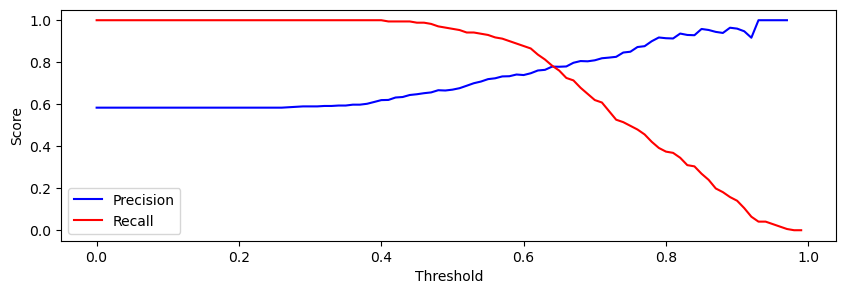

In [25]:
# plotting precision and recall
plt.figure(figsize=(10, 3))
plt.plot(scores_df_q3['threshold'], scores_df_q3['precision'], label='Precision', color='blue')
plt.plot(scores_df_q3['threshold'], scores_df_q3['recall'], label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [26]:
# point where precision and recall intersect
shared_values = scores_df_q3[scores_df_q3['precision'].round(2) == scores_df_q3['recall'].round(2)]
display(shared_values)
display(scores_df_q3.iloc[ 62:67 ])


,threshold,tp,fp,fn,tn,precision,recall
64,0.64,134,38,37,84,0.77907,0.783626


,threshold,tp,fp,fn,tn,precision,recall
62,0.62,143,45,28,77,0.760638,0.836257
63,0.63,139,43,32,79,0.763736,0.812865
64,0.64,134,38,37,84,0.779070,0.783626
65,0.65,130,37,41,85,0.778443,0.760234
66,0.66,124,35,47,87,0.779874,0.725146


Precision and Recall intersects at the threshold 0.64

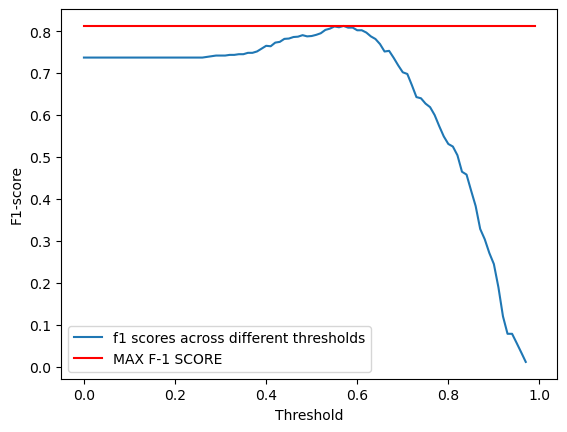

In [27]:
# QUESTION 4

# # f1 score calculation function
# def f1_score(precision, recall):
#     return (2 * (precision * recall)) / (precision + recall)

# f1 score column in previously created dataframe
scores_df_q3['f1_score'] = 2 * (scores_df_q3['precision'] * scores_df_q3['recall']) / (scores_df_q3['precision'] + scores_df_q3['recall'])

plt.plot(scores_df_q3['threshold'], scores_df_q3['f1_score'], label='f1 scores across different thresholds')
plt.plot(scores_df_q3['threshold'],np.repeat(scores_df_q3['f1_score'].max(), len(scores_df_q3)), color='red', label='MAX F-1 SCORE')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.legend()
plt.show()


In [28]:
# max f1 score
print('Max f1 score is: ', scores_df_q3['f1_score'].max())

# threshold at which max f1 score occurs
display(scores_df_q3[scores_df_q3['f1_score'] == scores_df_q3['f1_score'].max()])

Max f1 score is:  0.8124999999999999


,threshold,tp,fp,fn,tn,precision,recall,f1_score
57,0.57,156,57,15,65,0.732394,0.912281,0.8125


The threshold at which the F1 score is maximal = 0.57  

In [29]:
# QUESTION 5

# fn for training logistic regression model 
# (note: this will not exclude target column even if the df_train has target column in it)
def logreg_train(df_train, y_train, solver='liblinear', C=1.0, max_iter=1000):
    
    # initialize dict vectorizer
    dictionary_vectorizer = DictVectorizer(sparse=False)
    
    # create x train after vectorizing features
    X_train = dictionary_vectorizer.fit_transform(df_train[cat_cols + num_cols].to_dict(orient='records'))

    # create a models and fit the data
    logreg_model = LogisticRegression(solver=solver, C=C, max_iter=max_iter)
    # print(logreg_model) --> uncomment to check if the logistic regression model has the right params
    
    logreg_model.fit(X_train, y_train)

    return dictionary_vectorizer, logreg_model

In [30]:
# fn for making predictions using a model
def classification_model_predict(df_val_or_test, dictionary_vectorizer, model):
    
    # transform the val or test set features
    X_val_or_test = dictionary_vectorizer.transform(df_val_or_test[cat_cols + num_cols].to_dict(orient='records'))
    
    # get prediction probabilities of predicting 1
    y_pred = model.predict_proba(X_val_or_test)[:,1]
    
    return y_pred

In [31]:
# k fold cross validation
from sklearn.model_selection import KFold

# intializing a k fold cross validator that shuffles and creates 5 splits
k_fold_q5 = KFold(n_splits=5, shuffle=True, random_state=1)

kfold_auc_scores_q5 = []


for train_idx, val_idx in k_fold_q5.split(df_full_train):
    
    # split the df full train into train and validation sets using the indices of the current fold
    df_train_q5 = df_full_train.iloc[train_idx]
    df_val_q5 = df_full_train.iloc[val_idx]
    
    # extract the target values
    y_train_q5 = df_train_q5.converted.values
    y_val_q5 = df_val_q5.converted.values
    
    # we need not drop the target column as the fn created will do it
    
    # train and make predictions on logistic regression model with C=0.1 and max_iter=1000
    dv_q5, model_q5 = logreg_train(df_train_q5, y_train_q5)
    y_pred_q5 = classification_model_predict(df_val_q5, dv_q5, model_q5)
    
    # calculate AUC score
    kfold_auc_scores_q5.append(roc_auc_score(y_val_q5, y_pred_q5))


# find the standard deviation of the 5 fold cross validation AUC scores of the log reg model
print('standard deviation of the 5 fold cross validation AUC scores of the log reg model:')
print(np.std(kfold_auc_scores_q5))


standard deviation of the 5 fold cross validation AUC scores of the log reg model:
0.03580711942905165


The standard deviation of the 5 fold cross validation AUC scores of the log reg model is 0.036 (approx)

In [36]:
# QUESTION 6

# different values of hyperparameter C we need to check
C_list_q6 = [0.000001, 0.001, 1]

for C in C_list_q6:
    
    # intializing a k fold cross validator that shuffles and creates 5 splits
    k_fold_q6 = KFold(n_splits=5, shuffle=True, random_state=1)

    kfold_auc_scores_q6 = []

    for train_idx, val_idx in k_fold_q5.split(df_full_train):
        
        # split the df full train into train and validation sets using the indices of the current fold
        df_train_q6 = df_full_train.iloc[train_idx]
        df_val_q6 = df_full_train.iloc[val_idx]
        
        # extract the target values
        y_train_q6 = df_train_q6.converted.values
        y_val_q6 = df_val_q6.converted.values
        
        # we need not drop the target column as the fn created will do it
        
        # train and make predictions on logistic regression model with different C and max_iter=1000
        dv_q6, model_q6 = logreg_train(df_train_q6, y_train_q6, C=C)
        y_pred_q6 = classification_model_predict(df_val_q6, dv_q6, model_q6)
        
        # calculate AUC score
        kfold_auc_scores_q6.append(roc_auc_score(y_val_q5, y_pred_q5))
        

    # mean and std dev of AUC scores of different hyperparameters
    print()
    print(f'5 fold logistic regression models with C={C} produced AUC scores \
        with mean={round(np.mean(kfold_auc_scores_q6),3)} \
        and std dev={round(np.std(kfold_auc_scores_q6),3)}')
    print()




5 fold logistic regression models with C=1e-06 produced AUC scores         with mean=0.856         and std dev=0.0


5 fold logistic regression models with C=0.001 produced AUC scores         with mean=0.856         and std dev=0.0


5 fold logistic regression models with C=1 produced AUC scores         with mean=0.856         and std dev=0.0



The mean and standard deviation of AUC scores, </br>
when using different hyperparameters of C values of 0.000001, 0.001, 1 respectively, </br>
were equal (mean=0.855827 and std dev=0.0)